# Discharge Demo - Using the ArcGIS Python API
This notebook reviews the workflow for extracting data and generating a hydrograph for catchments nearest a user defined point. The pseudocode for this operation is as follows:
1. Get the user point, as lat/long coordinates (Alternatively, geocode address)
* Identify the HUC8 in which it is located
 * Search AGOL for a watershed boundary datatset
 * Retrive the HUC8 layer from the results
 * Query the HUC8 intersecting the user point and report its HUC8 value
* Extract all NWIS gage site locations for the selected HUC8
 * Form and send request to NWIS Service endpoint
 * Handle response to return coordinates of active gage sites in identified HUC8
 * Convert coordinates to feature geometry to feature set to feature layer
* Identify the gage site feature found nearest the user point
* Extract discharge data for selected gage site
 * Form and send request to NWIS Service endpoint
 * Handle response to build dataframe from discharge data
* Plot discharge hydrograph

In [21]:
#Import and authenticate the GIS module
from arcgis import GIS
from arcgis.features import FeatureLayer
from arcgis.geometry import Point, filters

#Connect to AGOL
gis = GIS('home')


Construct a Point object from the user coordinates
 * References: 
  * https://developers.arcgis.com/python/api-reference/arcgis.geometry.html#
  * https://developers.arcgis.com/python/api-reference/arcgis.geometry.html#point

In [2]:
# Set user coordinates
userLat = 36.0010
userLng = -78.9991

In [5]:
#Create the point object
pt = Point({"x" : userLng, 
                 "y" : userLat, 
                 "spatialReference" : {"wkid" : 4326}
           })
#Ensure the geometry is valid
print(pt.is_valid())

True


### Task 1. Finding Watershed
The watershed boundary dataset is served via ESRI's Living Atlas. 

In [7]:
#Search for a dataset of HUCs 
search_results = gis.content.search('"Watershed Boundary Dataset" owner:esri_environment',
                                    outside_org=True)
search_results

[<Item title:"Watershed Boundary Dataset HUC 4s" type:Feature Layer Collection owner:esri_environment>,
 <Item title:"Watershed Boundary Dataset HUC 12s" type:Feature Layer Collection owner:esri_environment>,
 <Item title:"Watershed Boundary Dataset HUC 10s" type:Feature Layer Collection owner:esri_environment>,
 <Item title:"Drought Aware" type:Web Mapping Application owner:esri_environment>,
 <Item title:"Watershed Boundary Dataset HUC 2s" type:Feature Layer Collection owner:esri_environment>,
 <Item title:"Watershed Boundary Dataset HUC 8s" type:Feature Layer Collection owner:esri_environment>,
 <Item title:"Watershed Boundary Dataset HUC 6s" type:Feature Layer Collection owner:esri_environment>]

<Item title:"Watershed Boundary Dataset HUC 8s" type:Feature Layer Collection owner:esri_environment>
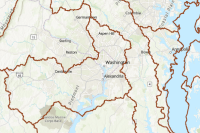

In [8]:
item = search_results[5]
item

In [9]:
theID = item.id
theID

'5bbefdcd2511472ea9abd0afedb85c7e'

In [10]:
#For future reference, retrieve Watershed from its item ID
item = gis.content.get('5bbefdcd2511472ea9abd0afedb85c7e')

In [11]:
layers = item.layers
for layer in layers:
    print (layer.properties.name, layer.properties.type)

HU08 Feature Layer


Layers: https://developers.arcgis.com/python/guide/working-with-feature-layers-and-features/

In [26]:
huc8 = layers[0]
for fld in huc8.properties.fields:
    print (fld.name)

OBJECTID
HUC8
NAME
Shape__Area
Shape__Length


In [13]:
#from arcgis.features import FeatureLayer
print(huc8.url)

https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/Watershed_Boundary_Dataset_HUC_8s/FeatureServer/0


https://developers.arcgis.com/labs/rest/query-a-feature-layer/

https://hydro.nationalmap.gov/arcgis/rest/services/wbd/MapServer/4/query?where=1%3D1&text=&objectIds=&time=&geometry=%7B%0D%0A%22x%22+%3A+-78.15%2C+%22y%22+%3A+36.00%2C+%22spatialReference%22+%3A+%7B%22wkid%22+%3A+4326%7D%0D%0A%7D&geometryType=esriGeometryPoint&inSR=4326&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&having=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&queryByDistance=&returnExtentOnly=false&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&featureEncoding=esriDefault&f=html

In [14]:
strRest = 'https://hydro.nationalmap.gov/arcgis/rest/services/wbd/MapServer/4/query?where=1%3D1&text=&objectIds=&time=&geometry=%7B%0D%0A%22x%22+%3A+-78.15%2C+%22y%22+%3A+36.00%2C+%22spatialReference%22+%3A+%7B%22wkid%22+%3A+4326%7D%0D%0A%7D&geometryType=esriGeometryPoint&inSR=4326&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&having=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&queryByDistance=&returnExtentOnly=false&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&featureEncoding=esriDefault&f=html'

In [15]:
strItems = strRest.split("&")
strDict = {}
for item in strItems[1:]:
    k,v = item.split('=')
    strDict[k]=v

In [16]:
strDict.keys()

dict_keys(['text', 'objectIds', 'time', 'geometry', 'geometryType', 'inSR', 'spatialRel', 'relationParam', 'outFields', 'returnGeometry', 'returnTrueCurves', 'maxAllowableOffset', 'geometryPrecision', 'outSR', 'having', 'returnIdsOnly', 'returnCountOnly', 'orderByFields', 'groupByFieldsForStatistics', 'outStatistics', 'returnZ', 'returnM', 'gdbVersion', 'historicMoment', 'returnDistinctValues', 'resultOffset', 'resultRecordCount', 'queryByDistance', 'returnExtentOnly', 'datumTransformation', 'parameterValues', 'rangeValues', 'quantizationParameters', 'featureEncoding', 'f'])

In [17]:
strDict['geometry']

'%7B%0D%0A%22x%22+%3A+-78.15%2C+%22y%22+%3A+36.00%2C+%22spatialReference%22+%3A+%7B%22wkid%22+%3A+4326%7D%0D%0A%7D'

Create the point used to select the HUC8

https://developers.arcgis.com/python/api-reference/arcgis.geometry.html?highlight=geometry#module-arcgis.geometry

In [18]:
#Ensure we can query the data
huc8.properties.capabilities

'Query,Extract'

https://developers.arcgis.com/python/api-reference/arcgis.geometry.filters.html

In [27]:
#Query the result into a featureset object
query_result = huc8.query(geometry_filter=filters.intersects(pt))

In [28]:
#Display the spatial reference of the dataset
query_result.spatial_reference

{'wkid': 102100, 'latestWkid': 3857}

In [29]:
#Convert the result to a spatial dataframe
sdf = query_result.sdf

In [30]:
#Display the data
m = sdf.spatial.plot()
#m.basemap = 'oceans'
m.draw(pt)
m

MapView(layout=Layout(height='400px', width='100%'))

In [31]:
sdf

,OBJECTID,HUC8,NAME,Shape__Area,Shape__Length,SHAPE
0,1440,03030002,Haw,6773583346.859375,551418.20656,"{""rings"": [[[-8873544.7811, 4349237.9355], [-8..."
